# Analyzing and visualizing CAM-SE output in Python

## Overview

We demonstrate a variety of options for analyzing and visualizing output from the Community Atmosphere Model (CAM) with the spectral element (SE) grid in Python. This notebook was developed for the ESDS [Collaborative Work Time on Unstructured Grids](https://ncar.github.io/esds/posts/2023/unstructured-grid-collab-1/), which took place on April 17, 2023. A recap of the related CAM-SE discussion can be found [here](https://ncar.github.io/esds/posts/2023/unstructured-grid-collab-1/#katie-dagon-cgd).

## Contents
1. [Regrid CAM-SE output using map file](#section1)
2. [Use a CAM-SE remap function to scale up](#section2)
3. [Regrid CAM-SE output using xESMF](#section3)
4. [Direct sparse matrix multiply-add](#section4)

## Imports

In [1]:
%load_ext watermark

import distributed
import ncar_jobqueue
import numpy as np
import opt_einsum
import scipy as sp
import xarray as xr
import xesmf

%watermark -iv

sys          : 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
xesmf        : 0.7.1
distributed  : 2023.4.1
json         : 2.0.9
ncar_jobqueue: 2021.4.14
xarray       : 2023.3.0
numpy        : 1.23.5
scipy        : 1.10.1
opt_einsum   : 3.3.0



## Spin up a Cluster

In [2]:
cluster = ncar_jobqueue.NCARCluster()
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.45:39748,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Distributed client with adaptive scaling

In [3]:
client = distributed.Client(cluster)
cluster.adapt(minimum_jobs=1, maximum_jobs=4);

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.45:39748,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Set CAM-SE output location and map file
Here we are using 3-hourly surface temperature (TS) output from a historical simulation using the ne120 grid (0.25deg resolution).

In [5]:
data_path = '/glade/campaign/cgd/ccr/jet/nanr_forKatie/3hrly/b.e13.B20TRC5CN.ne120_g16.003/'
data_file = 'b.e13.B20TRC5CN.ne120_g16.003.cam.h4.TS.2000010100Z-2000123121Z.nc'  # TS file is 3-hourly avg for year 2000

The map file is a set of weights that is used to remap the CAM-SE unstructured output to a regular latitude by longitude grid. This particular map file uses bilinear interpolation.

[ESMF_RegridWeightGen](https://earthsystemmodeling.org/docs/release/ESMF_8_0_1/ESMF_refdoc/node3.html#SECTION03020000000000000000) is a tool that can be used to generate map files, and [this ESMPy tutorial](https://earthsystemmodeling.org/esmpy_doc/release/latest/html/examples.html#regridding) has additional information on creating these files.

In [6]:
map_path = '/glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/'
map_file = 'map_ne120_to_0.23x0.31_bilinear.nc'

<a id='section1'></a>
## 1. Regrid CAM-SE output using map file

This method aims to produce a Python-based alternative to the [ncremap](https://nco.sourceforge.net/nco.html#ncremap-netCDF-Remapper) tool from the [NCO package](https://nco.sourceforge.net/nco.html). The benefits of this method could include remapping within a Python script or notebook, for example to visualize unstructured data without having to write a netCDF file, remap, and read it back in. See related discussion from [this issue](https://github.com/UXARRAY/uxarray/issues/183#issuecomment-1343388433) in the UXarray github repository, and [this example notebook](https://uxarray.readthedocs.io/en/latest/examples/005-to-geodataframe-for-holoviz.html) with visualization examples from the UXarray documentation.

### Read in map file (weights)

In [7]:
weights = xr.open_dataset(map_path + map_file)
weights

<xarray.Dataset>
Dimensions:        (src_grid_rank: 1, dst_grid_rank: 2, n_a: 777602,
                    n_b: 884736, nv_a: 3, nv_b: 4, n_s: 2654208)
Dimensions without coordinates: src_grid_rank, dst_grid_rank, n_a, n_b, nv_a,
                                nv_b, n_s
Data variables: (12/19)
    src_grid_dims  (src_grid_rank) int32 ...
    dst_grid_dims  (dst_grid_rank) int32 ...
    yc_a           (n_a) float64 ...
    yc_b           (n_b) float64 ...
    xc_a           (n_a) float64 ...
    xc_b           (n_b) float64 ...
    ...             ...
    area_b         (n_b) float64 ...
    frac_a         (n_a) float64 ...
    frac_b         (n_b) float64 ...
    col            (n_s) int32 ...
    row            (n_s) int32 ...
    S              (n_s) float64 ...
Attributes:
    title:               ESMF Offline Regridding Weight Generator
    normalization:       destarea
    map_method:          Bilinear remapping
    ESMF_regrid_method:  Bilinear
    conventions:         NCAR-CSM
    domain_a:            /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    domain_b:            /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    grid_file_src:       /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    grid_file_dst:       /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    CVS_revision:        6.3.0r

### Make source / destination grids

In [8]:
srclat = weights['yc_a']
srclon = weights['xc_a']
dstlat = weights['yc_b']
dstlon = weights['xc_b']
src_grid_dims = weights['src_grid_dims'].values
dst_grid_dims = weights['dst_grid_dims'].values

print(f"Src grid dims: {src_grid_dims}, dst grid dims: {dst_grid_dims}")

n_a = weights['n_a'].size  # col dimension
n_b = weights['n_b'].size  # row dimension
n_s = weights['n_s'].size  # nnz dimension

print(f"Map contains {n_b} rows, {n_a} cols and {n_s} nnz values")

rows = weights['row'][:] - 1  # row indices (1-based)
cols = weights['col'][:] - 1  # col indices (1-based)
nnzvals = weights['S'][:]  # nnz map values

Src grid dims: [777602], dst grid dims: [1152  768]
Map contains 884736 rows, 777602 cols and 2654208 nnz values


### Create sparse matrix map

In [9]:
sparse_map = sp.sparse.coo_matrix((nnzvals, (rows, cols)), shape=(n_b, n_a))
sparse_map

<884736x777602 sparse matrix of type '<class 'numpy.float64'>'
	with 2654208 stored elements in COOrdinate format>

### Read in CAM-SE output

In [10]:
tsfile = xr.open_dataset(data_path + data_file, chunks={"time": 50, "ncol": 50000})
tsfile

<xarray.Dataset>
Dimensions:       (lev: 30, ilev: 31, ncol: 777602, time: 2920, nbnd: 2)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2000-01-01 03:00:00 ... 2001-01-01 00:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/31)
    hyam          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybi          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    lat           (ncol) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(50,), meta=np.ndarray>
    TS            (time, ncol) float32 dask.array<chunksize=(50, 50000), meta=np.ndarray>
Attributes:
    np:               4
    ne:               120
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e13.B20TRC5CN.ne120_g16.003
    title:            UNSET
    logname:          
    host:             
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /projects/ccsm/inputdata/atm/cam/inic/homme/cami-mam3_0...
    topography_file:  /projects/ccsm/inputdata/atm/cam/topo/USGS-gtopo30_ne12...

### Extract surface temperature variable (TS)

In [11]:
ts = tsfile.TS
ts

<xarray.DataArray 'TS' (time: 2920, ncol: 777602)>
dask.array<open_dataset-bb5b27d0821608d3fc5037525bd2f985TS, shape=(2920, 777602), dtype=float32, chunksize=(50, 50000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2001-01-01 00:00:00
Dimensions without coordinates: ncol
Attributes:
    units:      K
    long_name:  Surface temperature (radiative)

### Apply sparse map onto first timestep of TS
Note: this is a time consuming step, so demonstrating only the first time index here

In [12]:
%%time
field_target = sparse_map @ ts.isel(time=0)

CPU times: user 2.53 s, sys: 116 ms, total: 2.64 s
Wall time: 33 s


In [13]:
field_target.shape

(884736,)

### Reshape 1-D vector to destination grid

In [14]:
data_out = np.reshape(field_target, dst_grid_dims, order='F')
print(f"Reshaped array now has dimensions {dst_grid_dims}")

Reshaped array now has dimensions [1152  768]


### Reshape destination grid to build structured data array

In [15]:
lat2d = np.reshape(dstlat.values, dst_grid_dims, order='F')
lon2d = np.reshape(dstlon.values, dst_grid_dims, order='F')

In [16]:
print(lat2d.shape, lon2d.shape)

(1152, 768) (1152, 768)


### Build data array with dimension and coordinates

In [17]:
ts_remap = xr.DataArray(
    data=data_out,
    dims=["lon", "lat"],
    coords=dict(
        lon=(["lon"], lon2d[:, 0]),
        lat=(["lat"], lat2d[0, :]),
    ),
)

In [18]:
ts_remap

<xarray.DataArray (lon: 1152, lat: 768)>
array([[244.04267883, 243.94797035, 243.71354076, ..., 231.61040262,
        231.07736837, 231.86198425],
       [244.04267883, 243.94817018, 243.71394044, ..., 231.61271724,
        231.07852571, 231.86198425],
       [244.04267883, 243.94837698, 243.71435405, ..., 231.61500008,
        231.07966716, 231.86198425],
       ...,
       [244.04267883, 243.95208424, 243.72176851, ..., 231.57748313,
        231.06090852, 231.86198425],
       [244.04267883, 243.95070604, 243.71901211, ..., 231.58848746,
        231.06641072, 231.86198425],
       [244.04267883, 243.94933473, 243.7162695 , ..., 231.59946073,
        231.07189739, 231.86198425]])
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0

### Visualize

CPU times: user 392 ms, sys: 47 ms, total: 439 ms
Wall time: 2.61 s


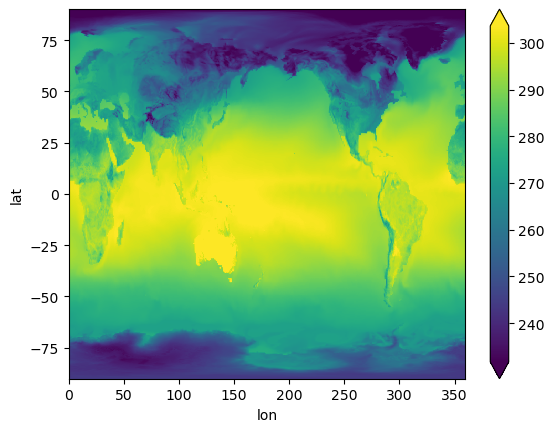

In [19]:
%%time
ts_remap.plot(x="lon", y="lat", robust=True);

<a id='section2'></a>
## 2. Use a CAM-SE remap function to scale up

This method builds on the first example, by creating a function to streamline the remapping process. See related [regridding script](https://github.com/sgyeager/mypyutils/blob/main/mypyutils/regrid_utils.py).


### Define a function to remap using weights file

In [20]:
def remap_camse(ds, dsw, varlst=[]):
    # dso = xr.full_like(ds.drop_dims('ncol'), np.nan)
    dso = ds.drop_dims('ncol').copy()
    lonb = dsw.xc_b.values.reshape([dsw.dst_grid_dims[1].values, dsw.dst_grid_dims[0].values])
    latb = dsw.yc_b.values.reshape([dsw.dst_grid_dims[1].values, dsw.dst_grid_dims[0].values])
    weights = sp.sparse.coo_matrix(
        (dsw.S, (dsw.row - 1, dsw.col - 1)), shape=[dsw.dims['n_b'], dsw.dims['n_a']]
    )
    if not varlst:
        for varname in list(ds):
            if 'ncol' in (ds[varname].dims):
                varlst.append(varname)
        if 'lon' in varlst:
            varlst.remove('lon')
        if 'lat' in varlst:
            varlst.remove('lat')
        if 'area' in varlst:
            varlst.remove('area')
    for varname in varlst:
        shape = ds[varname].shape
        invar_flat = ds[varname].values.reshape(-1, shape[-1])
        remapped_flat = weights.dot(invar_flat.T).T
        remapped = remapped_flat.reshape(
            [*shape[0:-1], dsw.dst_grid_dims[1].values, dsw.dst_grid_dims[0].values]
        )
        dimlst = list(ds[varname].dims[0:-1])
        dims = {}
        coords = {}
        for it in dimlst:
            dims[it] = dso.dims[it]
            coords[it] = dso.coords[it]
        dims['lat'] = int(dsw.dst_grid_dims[1])
        dims['lon'] = int(dsw.dst_grid_dims[0])
        coords['lat'] = latb[:, 0]
        coords['lon'] = lonb[0, :]
        remapped = xr.DataArray(remapped, coords=coords, dims=dims, attrs=ds[varname].attrs)
        dso = xr.merge([dso, remapped.to_dataset(name=varname)])
    return dso

### Read in CAM-SE output

In [21]:
tsfile = xr.open_dataset(data_path + data_file, chunks={"time": 50})
tsfile

<xarray.Dataset>
Dimensions:       (lev: 30, ilev: 31, ncol: 777602, time: 2920, nbnd: 2)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2000-01-01 03:00:00 ... 2001-01-01 00:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/31)
    hyam          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybi          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    lat           (ncol) float64 dask.array<chunksize=(777602,), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(50,), meta=np.ndarray>
    TS            (time, ncol) float32 dask.array<chunksize=(50, 777602), meta=np.ndarray>
Attributes:
    np:               4
    ne:               120
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e13.B20TRC5CN.ne120_g16.003
    title:            UNSET
    logname:          
    host:             
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /projects/ccsm/inputdata/atm/cam/inic/homme/cami-mam3_0...
    topography_file:  /projects/ccsm/inputdata/atm/cam/topo/USGS-gtopo30_ne12...

### Read in map file (weights)

In [22]:
weights = xr.open_dataset(map_path + map_file)
weights

<xarray.Dataset>
Dimensions:        (src_grid_rank: 1, dst_grid_rank: 2, n_a: 777602,
                    n_b: 884736, nv_a: 3, nv_b: 4, n_s: 2654208)
Dimensions without coordinates: src_grid_rank, dst_grid_rank, n_a, n_b, nv_a,
                                nv_b, n_s
Data variables: (12/19)
    src_grid_dims  (src_grid_rank) int32 ...
    dst_grid_dims  (dst_grid_rank) int32 ...
    yc_a           (n_a) float64 ...
    yc_b           (n_b) float64 ...
    xc_a           (n_a) float64 ...
    xc_b           (n_b) float64 ...
    ...             ...
    area_b         (n_b) float64 ...
    frac_a         (n_a) float64 ...
    frac_b         (n_b) float64 ...
    col            (n_s) int32 ...
    row            (n_s) int32 ...
    S              (n_s) float64 ...
Attributes:
    title:               ESMF Offline Regridding Weight Generator
    normalization:       destarea
    map_method:          Bilinear remapping
    ESMF_regrid_method:  Bilinear
    conventions:         NCAR-CSM
    domain_a:            /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    domain_b:            /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    grid_file_src:       /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    grid_file_dst:       /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    CVS_revision:        6.3.0r

### Apply remap function onto first timestep of TS
Note: this is a time consuming step, so demonstrating only the first time index here

In [23]:
%%time
out = remap_camse(tsfile.isel(time=0), weights)  # single timestep

CPU times: user 56.2 ms, sys: 637 ms, total: 693 ms
Wall time: 890 ms


In [24]:
out

<xarray.Dataset>
Dimensions:       (lev: 30, ilev: 31, nbnd: 2, lat: 768, lon: 1152)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
    time          object 2000-01-01 03:00:00
  * lat           (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon           (lon) float64 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Dimensions without coordinates: nbnd
Data variables: (12/28)
    hyam          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybi          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    ntrm          int32 ...
    ...            ...
    n2ovmr        float64 dask.array<chunksize=(), meta=np.ndarray>
    f11vmr        float64 dask.array<chunksize=(), meta=np.ndarray>
    f12vmr        float64 dask.array<chunksize=(), meta=np.ndarray>
    sol_tsi       float64 dask.array<chunksize=(), meta=np.ndarray>
    nsteph        int32 dask.array<chunksize=(), meta=np.ndarray>
    TS            (lat, lon) float64 244.0 244.0 244.0 ... 231.9 231.9 231.9
Attributes:
    np:               4
    ne:               120
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e13.B20TRC5CN.ne120_g16.003
    title:            UNSET
    logname:          
    host:             
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /projects/ccsm/inputdata/atm/cam/inic/homme/cami-mam3_0...
    topography_file:  /projects/ccsm/inputdata/atm/cam/topo/USGS-gtopo30_ne12...

### Visualize

CPU times: user 112 ms, sys: 1.47 ms, total: 114 ms
Wall time: 115 ms


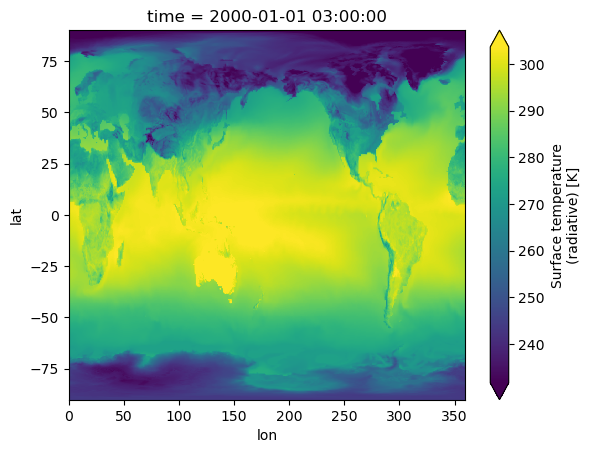

In [25]:
%%time
out.TS.plot(robust=True);

<a id='section3'></a>
## 3. Regrid CAM-SE output using xESMF
This method utilizes the [xESMF package](https://xesmf.readthedocs.io/en/latest/index.html) which has built-in regridding functionality. See a related discussion and example in [this ESDS blog post](https://ncar.github.io/esds/posts/2022/cam-se-regridding/).

### Define regridding function that constructs an xESMF regridder

In [26]:
def regrid_cam_se(dataset, weight_file):
    """
    Regrid CAM-SE output using an existing ESMF weights file.

    Parameters
    ----------
    dataset: xarray.Dataset
        Input dataset to be regridded. Must have the `ncol` dimension.
    weight_file: str or Path
        Path to existing ESMF weights file

    Returns
    -------
    regridded
        xarray.Dataset after regridding.
    """
    import numpy as np
    import xarray as xr

    assert isinstance(dataset, xr.Dataset)
    weights = xr.open_dataset(weight_file)

    # input variable shape
    in_shape = weights.src_grid_dims.load().data

    # Since xESMF expects 2D vars, we'll insert a dummy dimension of size-1
    if len(in_shape) == 1:
        in_shape = [1, in_shape.item()]

    # output variable shapew
    out_shape = weights.dst_grid_dims.load().data.tolist()[::-1]

    print(f"Regridding from {in_shape} to {out_shape}")

    # Insert dummy dimension
    vars_with_ncol = [name for name in dataset.variables if "ncol" in dataset[name].dims]
    updated = dataset.copy().update(
        dataset[vars_with_ncol].transpose(..., "ncol").expand_dims("dummy", axis=-2)
    )

    # construct a regridder
    # use empty variables to tell xesmf the right shape
    # https://github.com/pangeo-data/xESMF/issues/202
    dummy_in = xr.Dataset(
        {
            "lat": ("lat", np.empty((in_shape[0],))),
            "lon": ("lon", np.empty((in_shape[1],))),
        }
    )
    dummy_out = xr.Dataset(
        {
            "lat": ("lat", weights.yc_b.data.reshape(out_shape)[:, 0]),
            "lon": ("lon", weights.xc_b.data.reshape(out_shape)[0, :]),
        }
    )

    regridder = xesmf.Regridder(
        dummy_in,
        dummy_out,
        weights=weight_file,
        method="test",
        reuse_weights=True,
        periodic=True,
    )
    display(regridder)

    # Actually regrid, after renaming
    regridded = regridder(updated.rename({"dummy": "lat", "ncol": "lon"}))

    # merge back any variables that didn't have the ncol dimension
    # And so were not regridded
    return xr.merge([dataset.drop_vars(regridded.variables), regridded])

### Read in CAM-SE output

In [27]:
tsfile = xr.open_dataset(data_path + data_file, chunks={"time": 50, "ncol": -1})

### Apply the regridder

In [28]:
regridded = regrid_cam_se(tsfile, f"{map_path}/{map_file}")
regridded

Regridding from [1, 777602] to [768, 1152]


xESMF Regridder 
Regridding algorithm:       test 
Weight filename:            test_1x777602_768x1152_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (1, 777602) 
Output grid shape:          (768, 1152) 
Periodic in longitude?      True

<xarray.Dataset>
Dimensions:       (lev: 30, ilev: 31, time: 2920, nbnd: 2, lat: 768, lon: 1152)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2000-01-01 03:00:00 ... 2001-01-01 00:00:00
  * lat           (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon           (lon) float64 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Dimensions without coordinates: nbnd
Data variables: (12/29)
    hyam          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybi          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    ntrm          int32 ...
    ...            ...
    f11vmr        (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(50,), meta=np.ndarray>
    area          (lat, lon) float64 dask.array<chunksize=(768, 1152), meta=np.ndarray>
    TS            (time, lat, lon) float32 dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>
Attributes:
    np:               4
    ne:               120
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e13.B20TRC5CN.ne120_g16.003
    title:            UNSET
    logname:          
    host:             
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /projects/ccsm/inputdata/atm/cam/inic/homme/cami-mam3_0...
    topography_file:  /projects/ccsm/inputdata/atm/cam/topo/USGS-gtopo30_ne12...

### Visualize

CPU times: user 528 ms, sys: 95 ms, total: 623 ms
Wall time: 10.5 s


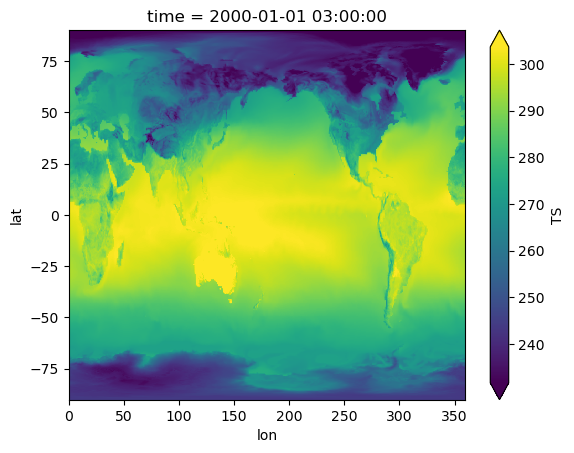

In [29]:
%%time
regridded.TS.isel(time=0).plot(robust=True);

<a id='section4'></a>
## 4. Direct sparse matrix multiply-add

This method uses the weights to create a `pydata/sparse` matrix, then uses `xr.dot` (≡ `np.einsum`). This approach is identical to methods 1, 2; but with `pydata/sparse` which in theory should work well with Dask. This *should* support chunking along `ncol` but doesn't work because of [a sparse bug](https://github.com/pydata/sparse/issues/589). So instead we work-around the bug using the [very cool opt_einsum package](https://dgasmith.github.io/opt_einsum/).

### Define a function that reads in map file (weights) and constructs a sparse array

In [30]:
def read_xesmf_weights_file(filename):
    import numpy as np
    import sparse
    import xarray as xr

    weights = xr.open_dataset(filename)

    # input variable shape
    in_shape = weights.src_grid_dims.load().data

    # output variable shape
    out_shape = weights.dst_grid_dims.load().data.tolist()[::-1]

    print(f"Regridding from {in_shape} to {out_shape}")

    rows = weights['row'] - 1  # row indices (1-based)
    cols = weights['col'] - 1  # col indices (1-based)

    # construct a sparse array,
    # reshape to 3D : lat, lon, ncol
    # This reshaping should allow optional chunking along
    # lat, lon later
    sparse_array_data = sparse.COO(
        coords=np.stack([rows.data, cols.data]),
        data=weights.S.data,
        shape=(weights.sizes["n_b"], weights.sizes["n_a"]),
        fill_value=0,
    ).reshape((*out_shape, -1))

    # Create a DataArray with sparse weights and the output coordinates
    xsparse_wgts = xr.DataArray(
        sparse_array_data,
        dims=("lat", "lon", "ncol"),
        # Add useful coordinate information, this will get propagated to the output
        coords={
            "lat": ("lat", weights.yc_b.data.reshape(out_shape)[:, 0]),
            "lon": ("lon", weights.xc_b.data.reshape(out_shape)[0, :]),
        },
        # propagate useful information like regridding algorithm
        attrs=weights.attrs,
    )

    return xsparse_wgts

### Read in weights

In [31]:
xsparse_wgts = read_xesmf_weights_file(map_path + map_file)
xsparse_wgts

Regridding from [777602] to [768, 1152]


Format,coo
Data Type,float64
Shape,"(768, 1152, 777602)"
nnz,2654208
Density,3.858014768480534e-06
Read-only,True
Size,50.6M
Storage ratio,0.0


### Read in CAM-SE output

In [32]:
tsfile = xr.open_dataset(data_path + data_file, chunks={"time": 1, "ncol": -1})
tsfile

<xarray.Dataset>
Dimensions:       (lev: 30, ilev: 31, ncol: 777602, time: 2920, nbnd: 2)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2000-01-01 03:00:00 ... 2001-01-01 00:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/31)
    hyam          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybi          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    lat           (ncol) float64 dask.array<chunksize=(777602,), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    TS            (time, ncol) float32 dask.array<chunksize=(1, 777602), meta=np.ndarray>
Attributes:
    np:               4
    ne:               120
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e13.B20TRC5CN.ne120_g16.003
    title:            UNSET
    logname:          
    host:             
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /projects/ccsm/inputdata/atm/cam/inic/homme/cami-mam3_0...
    topography_file:  /projects/ccsm/inputdata/atm/cam/topo/USGS-gtopo30_ne12...

### Compute

Now that we have weights, we compute the "dot product" using [xr.dot](https://docs.xarray.dev/en/stable/generated/xarray.dot.html). `xr.dot` uses [numpy.einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) under the hood, which dispatches to `sparse.einsum`. If we do this we get an error due to [a bug](https://github.com/pydata/sparse/issues/589).

In [33]:
%xmode Minimal

regridded = xr.dot(
    tsfile.TS,
    # could chunk differently here
    xsparse_wgts.chunk(),
    # This dimension will be "contracted"
    # or summmed over after multiplying by the weights
    dims="ncol",
)
regridded

Exception reporting mode: Minimal


TypeError: einsum() got an unexpected keyword argument 'dtype'

### Instead use opt_einsum

Turns out we can use the very cool [opt_einsum](https://dgasmith.github.io/opt_einsum/) package instead. `opt_einsum.contract` is a drop-in replacement for `numpy.einsum` (which  powers `xr.dot`) so we'll just [monkey-patch](https://en.wikipedia.org/wiki/Monkey_patch) this in to avoid redoing a [bunch of xarray code](https://github.com/pydata/xarray/blob/68bae08874d05e448eb5c9f522afb62e39146f33/xarray/core/computation.py#L1622) that converts dimension names to the "subscript string" that `opt_einsum.contract` expects. Seems like xarray could [support opt_einsum](https://github.com/pydata/xarray/issues/7764) as an opt-in.

In [34]:
opt_einsum.contract("tc,yxc->tyx", tsfile.TS.data, xsparse_wgts.chunk().data)

dask.array<transpose, shape=(2920, 768, 1152), dtype=float64, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>

### Define a function to apply weights using this method

In [35]:
def apply_weights(dataset, weights):
    def _apply(da):
        # 🐵 🔧
        xr.core.duck_array_ops.einsum = opt_einsum.contract

        ans = xr.dot(
            da,
            weights,
            # This dimension will be "contracted"
            # or summmed over after multiplying by the weights
            dims="ncol",
        )

        # 🐵 🔧 : restore back to original
        xr.core.duck_array_ops.einsum = np.einsum

        return ans

    vars_with_ncol = [
        name
        for name, array in dataset.variables.items()
        if "ncol" in array.dims and name not in weights.coords
    ]
    regridded = dataset[vars_with_ncol].map(_apply)

    # merge in other variables, but skip those that are already set
    # like lat, lon
    return xr.merge([dataset.drop_vars(regridded.variables), regridded])

### Apply weights

In [36]:
regridded = apply_weights(tsfile, xsparse_wgts.chunk())
regridded

<xarray.Dataset>
Dimensions:       (lev: 30, ilev: 31, time: 2920, nbnd: 2, lat: 768, lon: 1152)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2000-01-01 03:00:00 ... 2001-01-01 00:00:00
  * lat           (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon           (lon) float64 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Dimensions without coordinates: nbnd
Data variables: (12/29)
    hyam          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybi          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    ntrm          int32 ...
    ...            ...
    f11vmr        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    area          (lat, lon) float64 dask.array<chunksize=(768, 1152), meta=np.ndarray>
    TS            (time, lat, lon) float64 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
Attributes:
    np:               4
    ne:               120
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e13.B20TRC5CN.ne120_g16.003
    title:            UNSET
    logname:          
    host:             
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /projects/ccsm/inputdata/atm/cam/inic/homme/cami-mam3_0...
    topography_file:  /projects/ccsm/inputdata/atm/cam/topo/USGS-gtopo30_ne12...

### Visualize

CPU times: user 223 ms, sys: 74.8 ms, total: 298 ms
Wall time: 878 ms


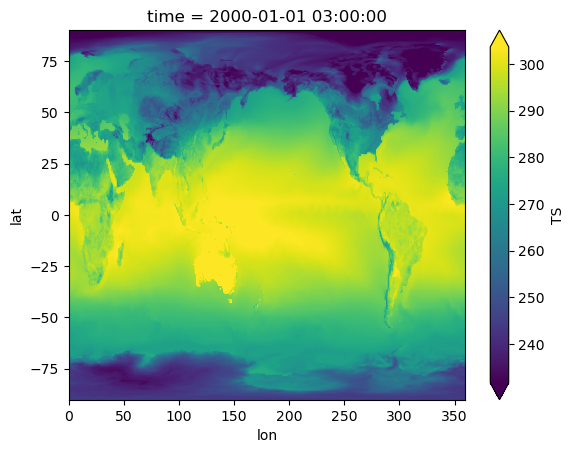

In [37]:
%%time
regridded.TS.isel(time=0).compute().plot(robust=True);

### Chunking in space

Let's try chunking along `lon`. This is useless since you'll always read all `ncol` in, but it illustrates the point. Note that these chunk sizes are very small, so this is probably only useful for a much higher-resolution output grid.

In [38]:
regridded = apply_weights(tsfile, xsparse_wgts.chunk(lon=200))
regridded

<xarray.Dataset>
Dimensions:       (lev: 30, ilev: 31, time: 2920, nbnd: 2, lat: 768, lon: 1152)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2000-01-01 03:00:00 ... 2001-01-01 00:00:00
  * lat           (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon           (lon) float64 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Dimensions without coordinates: nbnd
Data variables: (12/29)
    hyam          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybi          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    ntrm          int32 ...
    ...            ...
    f11vmr        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    area          (lat, lon) float64 dask.array<chunksize=(768, 200), meta=np.ndarray>
    TS            (time, lat, lon) float64 dask.array<chunksize=(1, 768, 200), meta=np.ndarray>
Attributes:
    np:               4
    ne:               120
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e13.B20TRC5CN.ne120_g16.003
    title:            UNSET
    logname:          
    host:             
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /projects/ccsm/inputdata/atm/cam/inic/homme/cami-mam3_0...
    topography_file:  /projects/ccsm/inputdata/atm/cam/topo/USGS-gtopo30_ne12...

### Visualize

CPU times: user 582 ms, sys: 96.9 ms, total: 679 ms
Wall time: 3.67 s


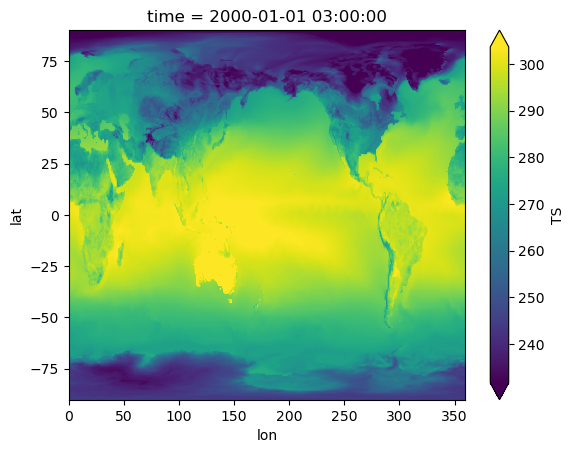

In [39]:
%%time
regridded.TS.isel(time=0).compute().plot(robust=True);

### Timing performance for core multiply-add
Testing the model or the core operation that would happen on every dask block. `data.data` is a numpy array, and `xsparse_weights.data` is a `sparse.COO` array. 

Does the order of operations matter?

In [40]:
data = tsfile.TS.isel(time=[0]).load()

In [41]:
%timeit np.einsum('tc, yxc->tyx', data.data, xsparse_wgts.data).todense()
%timeit opt_einsum.contract('tc, yxc->tyx', data.data, xsparse_wgts.data)

13.7 s ± 748 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
82.5 ms ± 789 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%timeit np.einsum('yxc, tc->yxt', xsparse_wgts.data, data.data).todense()
%timeit opt_einsum.contract('yxc, tc->yxt', xsparse_wgts.data, data.data)

146 ms ± 3.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
279 ms ± 7.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Summary of the timing test:
- Order of operations matters, particularly when calling `np.einsum`.
- For best performance use `opt_einsum.contract` and provide the field variable first, and weights second.

## Summary
In this blog post we've explored 4 methods to remap and visualize CAM-SE unstructured output in Python. Methods [1](#section1) and [2](#section2) provide a basic version of remapping using an ESMF weights file, mimicking the NCO tool `ncremap` while allowing the user to perform the remapping in a Python or Jupyter notebook environment. [Method 3](#section3) demonstrates the use of xESMF for this purpose, with similar performance. [Method 4](#section4) expands on the approach of methods 1 and 2 to allow for scaling with Dask.

We look forward to feedback from users on this code, and in particular which methods work well for different applications!

### Further reading
Here are some additional methods to explore that came up in discussions around this topic. Let us know if you try these out!
- Triangulate using Datashader and Holoviews: [Example 1](https://github.com/UXARRAY/uxarray/issues/183#issuecomment-1343274909), [Example 2](https://ncar.github.io/esds/posts/2021/cesm-datashader/)
- [Represent unstructured grid as polygons](https://github.com/UXARRAY/uxarray/issues/183#issuecomment-1343809123)
- [TempestRemap](https://github.com/ClimateGlobalChange/tempestremap)
- [Xoak](https://ncar.github.io/esds/posts/2021/multiple_index_xarray_xoak/)